# Part 1 - Clean Raw Data

In this file, we clean the data mentioned in _Forecasting the Volatility of Stock Price Index: A Hybrid Model Integrating LSTM with Multiple GARCH-Type Models_ by Kim and Won. Specifically, we want to extract 6 pieces of data.  
These are: 
- the KOSPI 200 (Korea Composite Stock Price Index of the top 200 companies by market cap)  
- the KOSPI 200 log difference return
- the 3-year Korean government bond interest rate
- the 3-year Korean Corporate AA bond rate
- the price of crude oil
-  the price of gold.

The data set is taken daily, and spans from Feb 1st 2010 to Feb 1st 2024. After cleaning, we have 3304 combined data points for training and testing. 

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model

In [63]:
df1 = pd.read_excel("./excel_data/kospi_200_index.xlsx") # korea stock exchange index
df2 = pd.read_excel("./excel_data/3_year_gov_bond_rates.xlsx") # 3 year gov bond interest rates
df3 = pd.read_excel("./excel_data/corporate_bond_spreads.xlsx") # excess return on korean corporate bonds over government bonds
df4 = pd.read_excel("./excel_data/crude_oil_prices.xlsx") # brent crude oil prices
df5 = pd.read_excel("./excel_data/gold_prices.xlsx") # gold prices

In [64]:
# convert all "date" columns to date-time object
df1['date'] = pd.to_datetime(df1['date'])
df2['date'] = pd.to_datetime(df2['date'])
df3['date'] = pd.to_datetime(df3['date'])
df4['date'] = pd.to_datetime(df4['date'])
df5['date'] = pd.to_datetime(df5['date'])

**Create the KOSPI 200 Index Log Return**  
Since the most recent values are at the top, we have to reverse the dataframe / calculate log return / reverse the dataframe again

In [66]:
# reverse the dataframe
df1_reversed = df1.iloc[::-1].reset_index(drop=True)

# calculate log return
df1_reversed['log_return_kospi'] = np.log(df1_reversed['price'] / df1_reversed['price'].shift(1))

# drop the top value of the dataframe because it is "NaN"
df1_reversed = df1_reversed.drop(index=0).reset_index(drop=True)

# restore original order of the dataframe
df1 = df1_reversed.iloc[::-1].reset_index(drop=True)

In [67]:
# rename 'price' columns to be unique
df1 = df1.rename(columns={'price': 'price_kospi_raw'})
df2 = df2.rename(columns={'price': 'interest_rate_government'})
df3 = df3.rename(columns={'price': 'interest_rate_corporate_spread'})
df4 = df4.rename(columns={'price': 'price_oil'})
df5 = df5.rename(columns={'price': 'price_gold'})

In [68]:
# merge df1, df2, df3, df4, df5 
# since df3 has the fewest rows, we will merge on df3 first
merged_df1 = pd.merge(df3, df2, on = "date", how = "inner")
# add corporate spread to interest rate
merged_df1['interest_rate_corporate'] = merged_df1['interest_rate_corporate_spread'] + merged_df1['interest_rate_government']
# drop the old column "interest_rate_corporate_spread"
merged_df1.drop(columns='interest_rate_corporate_spread', inplace=True)

# merge everything else
merged_df2 = pd.merge(merged_df1, df1, on = "date", how = "inner")
merged_df3 = pd.merge(merged_df2, df4, on = "date", how = "inner")
merged_df4 = pd.merge(merged_df3, df5, on = "date", how = "inner")

In [70]:
# view data
merged_df4.head()

,date,interest_rate_government,interest_rate_corporate,price_kospi_raw,log_return_kospi,price_oil,price_gold
0,2024-02-01,3.266,3.996,342.41,0.018184,73.82,2054.99
1,2024-01-31,3.261,3.991,336.24,-0.003681,75.85,2039.52
2,2024-01-30,3.267,4.007,337.48,-0.001066,77.82,2037.01
3,2024-01-29,3.304,4.044,337.84,0.010803,76.78,2033.23
4,2024-01-26,3.262,4.002,334.21,0.001228,78.01,2018.52


In [72]:
# re-arrange column order for clarity
df6 = merged_df4[['date', 'price_kospi_raw', 'log_return_kospi', 'interest_rate_government', 
                  'interest_rate_corporate', 'price_oil', 'price_gold' ]]

In [76]:
df6.head()

,date,price_kospi_raw,log_return_kospi,interest_rate_government,interest_rate_corporate,price_oil,price_gold
0,2024-02-01,342.41,0.018184,3.266,3.996,73.82,2054.99
1,2024-01-31,336.24,-0.003681,3.261,3.991,75.85,2039.52
2,2024-01-30,337.48,-0.001066,3.267,4.007,77.82,2037.01
3,2024-01-29,337.84,0.010803,3.304,4.044,76.78,2033.23
4,2024-01-26,334.21,0.001228,3.262,4.002,78.01,2018.52


**Calculate Realized Volatility**  
We want to predict realized volatility with our model. To calculate realized volatility, we will use "price_kospi_raw". We will use a rolling window of 7 days to calculate realized volatility. We use 7 days instead of the 22 days in the paper due to hardware constraints. 

In [80]:
# we need to flip the dataframe so oldest results are at the top
df6_reversed = df6.iloc[::-1].reset_index(drop=True)

# Define the maximum window size
# we're not following the author's window size because our computer isn't as good as their's
max_window_size = 7 

# Initialize a list to store realized volatility values
realized_volatility = []

# Loop over each row in df6
# remember that i starts from 0
for i in range(len(df6_reversed)):
    # Get the subset of log returns starting from the current row
    # remaining returns is a subset of the dataframe df6_reversed
    remaining_returns = df6_reversed['log_return_kospi'].iloc[i:] 
    
    # Limit the number of rows to the max window size
    if len(remaining_returns) > max_window_size:
        # here, we truncate our data so we only get to the 7th value
        # inclusive of the 7th value (because index starts at 0)
        remaining_returns = remaining_returns.iloc[:max_window_size]
    
    # Number of days in the current window (ρ_t)
    rho_t = len(remaining_returns)
    
    if rho_t > 1:  # Ensure at least two data points to compute variance
        # Calculate the mean of the remaining returns
        mean_return = remaining_returns.mean()
        
        # Calculate realized volatility (standard deviation of mean-centered returns)
        rv_t = np.sqrt((1 / rho_t) * np.sum((remaining_returns - mean_return) ** 2))
    else:
        rv_t = np.nan  # Not enough data to compute volatility
    
    realized_volatility.append(rv_t)

# Use .loc to avoid SettingWithCopyWarning
df6_reversed.loc[:, 'realized_volatility'] = realized_volatility

# reverse the dataframe so newest results are on the top
df6 = df6_reversed.iloc[::-1].reset_index(drop=True)

# drop the top value because it is a "NaN"
df6 = df6.drop(index=0).reset_index(drop=True)
# drop all rows with "NaN"
df6 = df6.dropna()
df6

# now our data goes from 2010/02/02 to 2024/01/31

,date,price_kospi_raw,log_return_kospi,interest_rate_government,interest_rate_corporate,price_oil,price_gold,realized_volatility
0,2024-01-31,336.24,-0.003681,3.261,3.991,75.85,2039.52,0.010932
1,2024-01-30,337.48,-0.001066,3.267,4.007,77.82,2037.01,0.009749
2,2024-01-29,337.84,0.010803,3.304,4.044,76.78,2033.23,0.008876
3,2024-01-26,334.21,0.001228,3.262,4.002,78.01,2018.52,0.008171
4,2024-01-25,333.80,0.001589,3.314,4.054,77.36,2020.84,0.007573
...,...,...,...,...,...,...,...,...
3306,2010-02-08,203.37,-0.008276,4.230,5.260,71.89,1062.85,0.009932
3307,2010-02-05,205.06,-0.031962,4.225,5.265,71.19,1066.25,0.015218
3308,2010-02-04,211.72,-0.000661,4.280,5.320,73.14,1063.53,0.015026
3309,2010-02-03,211.86,0.012300,4.270,5.320,76.98,1109.80,0.015767


Text(0, 0.5, 'Realized Volatility')

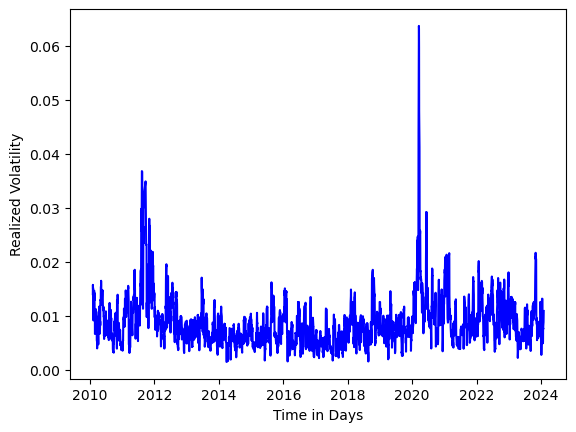

In [81]:
# lets graph the realized volatility
plt.plot(df6_reversed['date'], df6_reversed['realized_volatility'], color='blue')
plt.xlabel("Time in Days")
plt.ylabel("Realized Volatility")

We can see that the realized volatility is consistent with the real world. The spike in 2020 coincides with Covid-19.

**Split into Training and Testing Data Sets**  
We will follow the convention from the paper and use 66% of the data to train and 34% of the data to test.

In [85]:
num_rows = df6.shape[0]
print(num_rows)

3304


We can see that we have 3304 data points.

In [87]:
split_index = int(0.34 * num_rows) 
row_34 = df6.iloc[split_index]
print(row_34)

date                        2019-05-17 00:00:00
price_kospi_raw                          264.35
log_return_kospi                      -0.006185
interest_rate_government                   1.67
interest_rate_corporate                    1.97
price_oil                                 62.76
price_gold                              1277.53
realized_volatility                    0.004144
Name: 1124, dtype: object


We see that we will split the data on 2019/05/17

In [89]:
df_testing_data =  df6.iloc[:split_index] # data from 2019/05/20 to 2024/01/31 (only trading days in dataset)
df_training_data = df6.iloc[split_index:] # data from 2010/02/02 to 2019/05/17

In [90]:
# put oldest data on top
df_testing_data = df_testing_data.iloc[::-1].reset_index(drop=True)
df_training_data = df_training_data.iloc[::-1].reset_index(drop=True)

In [91]:
df_testing_data.head()

,date,price_kospi_raw,log_return_kospi,interest_rate_government,interest_rate_corporate,price_oil,price_gold,realized_volatility
0,2019-05-20,264.96,0.002305,1.682,1.982,63.10,1277.82,0.005699
1,2019-05-21,266.12,0.004368,1.662,1.962,62.99,1274.68,0.006898
2,2019-05-22,266.65,0.001990,1.668,1.958,61.42,1273.34,0.006614
3,2019-05-23,266.38,-0.001013,1.648,1.938,57.91,1283.45,0.008985
4,2019-05-24,264.42,-0.007385,1.643,1.933,58.63,1284.93,0.009015


In [92]:
df_testing_data.tail()

,date,price_kospi_raw,log_return_kospi,interest_rate_government,interest_rate_corporate,price_oil,price_gold,realized_volatility
1118,2024-01-25,333.80,0.001589,3.314,4.054,77.36,2020.84,0.007573
1119,2024-01-26,334.21,0.001228,3.262,4.002,78.01,2018.52,0.008171
1120,2024-01-29,337.84,0.010803,3.304,4.044,76.78,2033.23,0.008876
1121,2024-01-30,337.48,-0.001066,3.267,4.007,77.82,2037.01,0.009749
1122,2024-01-31,336.24,-0.003681,3.261,3.991,75.85,2039.52,0.010932


In [93]:
df_training_data.head()

,date,price_kospi_raw,log_return_kospi,interest_rate_government,interest_rate_corporate,price_oil,price_gold,realized_volatility
0,2010-02-02,209.27,-0.007095,4.280,5.330,77.23,1114.45,0.014052
1,2010-02-03,211.86,0.012300,4.270,5.320,76.98,1109.80,0.015767
2,2010-02-04,211.72,-0.000661,4.280,5.320,73.14,1063.53,0.015026
3,2010-02-05,205.06,-0.031962,4.225,5.265,71.19,1066.25,0.015218
4,2010-02-08,203.37,-0.008276,4.230,5.260,71.89,1062.85,0.009932


In [95]:
df_training_data.tail()

,date,price_kospi_raw,log_return_kospi,interest_rate_government,interest_rate_corporate,price_oil,price_gold,realized_volatility
2176,2019-05-13,268.72,-0.012353,1.721,2.021,61.04,1299.91,0.007046
2177,2019-05-14,268.57,-0.000558,1.711,2.011,61.78,1296.92,0.006094
2178,2019-05-15,269.64,0.003976,1.710,2.010,62.02,1296.49,0.006090
2179,2019-05-16,265.99,-0.013629,1.675,1.975,62.87,1286.72,0.006016
2180,2019-05-17,264.35,-0.006185,1.670,1.970,62.76,1277.53,0.004144


**Fit GARCH, EGARCH, EWMA Parameters**  
We will fit the GARCH, EGARCH, and EWMA parameters over the training set. 

In [98]:
garch11 = arch_model(df_training_data['log_return_kospi'], vol='GARCH', p=1, q=1, rescale = False)
fitted_model = garch11.fit()
print(fitted_model.summary())
# omega = 1.9716e-06 = 0.0000019716
# alpha = 0.0500
# beta = 0.9300

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6780435129.414104
Iteration:      2,   Func. Count:     18,   Neg. LLF: -7141.252633118793
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7141.252642163106
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2
                     Constant Mean - GARCH Model Results                      
Dep. Variable:       log_return_kospi   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                7141.25
Distribution:                  Normal   AIC:                          -14274.5
Method:            Maximum Likelihood   BIC:                          -14251.8
                                        No. Observations:                 2181
Date:                Fri, Dec 13 2024   Df Residuals:                     2180
Time:          

In [99]:
# EGARCH Model
egarch11 = arch_model(df_training_data['log_return_kospi'], vol='EGARCH',  p=1, q=1, mean='Constant', dist='Normal',rescale = False)
fitted_modelv2 = egarch11.fit()
print(fitted_modelv2.summary())
# omega = -0.1462
# alpha = 0.1077
# beta = 0.9839

Iteration:      1,   Func. Count:      6,   Neg. LLF: 23820664.59879385
Iteration:      2,   Func. Count:     19,   Neg. LLF: 10960704988.787422
Iteration:      3,   Func. Count:     28,   Neg. LLF: 1292396975.0523145
Iteration:      4,   Func. Count:     39,   Neg. LLF: -7129.172465004797
Iteration:      5,   Func. Count:     45,   Neg. LLF: 1261890476.124195
Iteration:      6,   Func. Count:     53,   Neg. LLF: -7138.237071445242
Iteration:      7,   Func. Count:     58,   Neg. LLF: -7138.244145115884
Iteration:      8,   Func. Count:     63,   Neg. LLF: -7138.2443817964595
Iteration:      9,   Func. Count:     68,   Neg. LLF: -7138.244385779877
Iteration:     10,   Func. Count:     72,   Neg. LLF: -7138.244385796414
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7138.244385779877
            Iterations: 10
            Function evaluations: 72
            Gradient evaluations: 10
                     Constant Mean - EGARCH Model Results    

In [101]:
# Find optimal EWMA parameters
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
ewma_model = SimpleExpSmoothing(df_training_data['log_return_kospi']).fit()
optimal_alpha = ewma_model.model.params['smoothing_level']
# we can think of alpha as 1 - lambda
print("lambda = ", 1 - optimal_alpha)
# thus we know the rho = lambda parameter as defined by the paper
# rho = 0.985 Round for convenience
# 1 - rho = 0.015 

lambda =  0.9848781815492367


In [103]:
# add parameters into the dataframes
df_training_data = df_training_data.assign (
    omega_garch = 0.0000019716, 
    alpha_garch = 0.0500,
    beta_garch = 0.9300, 
    omega_egarch = -0.1462, 
    alpha_egarch = 0.1077, 
    beta_egarch = 0.9839, 
    rho_ewma = 0.985, 
    one_minus_rho_ewma = 0.015
)
df_training_data

,date,price_kospi_raw,log_return_kospi,interest_rate_government,interest_rate_corporate,price_oil,price_gold,realized_volatility,omega_garch,alpha_garch,beta_garch,omega_egarch,alpha_egarch,beta_egarch,rho_ewma,one_minus_rho_ewma
0,2010-02-02,209.27,-0.007095,4.280,5.330,77.23,1114.45,0.014052,0.000002,0.05,0.93,-0.1462,0.1077,0.9839,0.985,0.015
1,2010-02-03,211.86,0.012300,4.270,5.320,76.98,1109.80,0.015767,0.000002,0.05,0.93,-0.1462,0.1077,0.9839,0.985,0.015
2,2010-02-04,211.72,-0.000661,4.280,5.320,73.14,1063.53,0.015026,0.000002,0.05,0.93,-0.1462,0.1077,0.9839,0.985,0.015
3,2010-02-05,205.06,-0.031962,4.225,5.265,71.19,1066.25,0.015218,0.000002,0.05,0.93,-0.1462,0.1077,0.9839,0.985,0.015
4,2010-02-08,203.37,-0.008276,4.230,5.260,71.89,1062.85,0.009932,0.000002,0.05,0.93,-0.1462,0.1077,0.9839,0.985,0.015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2176,2019-05-13,268.72,-0.012353,1.721,2.021,61.04,1299.91,0.007046,0.000002,0.05,0.93,-0.1462,0.1077,0.9839,0.985,0.015
2177,2019-05-14,268.57,-0.000558,1.711,2.011,61.78,1296.92,0.006094,0.000002,0.05,0.93,-0.1462,0.1077,0.9839,0.985,0.015
2178,2019-05-15,269.64,0.003976,1.710,2.010,62.02,1296.49,0.006090,0.000002,0.05,0.93,-0.1462,0.1077,0.9839,0.985,0.015
2179,2019-05-16,265.99,-0.013629,1.675,1.975,62.87,1286.72,0.006016,0.000002,0.05,0.93,-0.1462,0.1077,0.9839,0.985,0.015


In [104]:
df_testing_data = df_testing_data.assign (
    omega_garch = 0.0000019716, 
    alpha_garch = 0.0500,
    beta_garch = 0.9300, 
    omega_egarch = -0.1462, 
    alpha_egarch = 0.1077, 
    beta_egarch = 0.9839, 
    rho_ewma = 0.985, 
    one_minus_rho_ewma = 0.015
)
df_testing_data

,date,price_kospi_raw,log_return_kospi,interest_rate_government,interest_rate_corporate,price_oil,price_gold,realized_volatility,omega_garch,alpha_garch,beta_garch,omega_egarch,alpha_egarch,beta_egarch,rho_ewma,one_minus_rho_ewma
0,2019-05-20,264.96,0.002305,1.682,1.982,63.10,1277.82,0.005699,0.000002,0.05,0.93,-0.1462,0.1077,0.9839,0.985,0.015
1,2019-05-21,266.12,0.004368,1.662,1.962,62.99,1274.68,0.006898,0.000002,0.05,0.93,-0.1462,0.1077,0.9839,0.985,0.015
2,2019-05-22,266.65,0.001990,1.668,1.958,61.42,1273.34,0.006614,0.000002,0.05,0.93,-0.1462,0.1077,0.9839,0.985,0.015
3,2019-05-23,266.38,-0.001013,1.648,1.938,57.91,1283.45,0.008985,0.000002,0.05,0.93,-0.1462,0.1077,0.9839,0.985,0.015
4,2019-05-24,264.42,-0.007385,1.643,1.933,58.63,1284.93,0.009015,0.000002,0.05,0.93,-0.1462,0.1077,0.9839,0.985,0.015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118,2024-01-25,333.80,0.001589,3.314,4.054,77.36,2020.84,0.007573,0.000002,0.05,0.93,-0.1462,0.1077,0.9839,0.985,0.015
1119,2024-01-26,334.21,0.001228,3.262,4.002,78.01,2018.52,0.008171,0.000002,0.05,0.93,-0.1462,0.1077,0.9839,0.985,0.015
1120,2024-01-29,337.84,0.010803,3.304,4.044,76.78,2033.23,0.008876,0.000002,0.05,0.93,-0.1462,0.1077,0.9839,0.985,0.015
1121,2024-01-30,337.48,-0.001066,3.267,4.007,77.82,2037.01,0.009749,0.000002,0.05,0.93,-0.1462,0.1077,0.9839,0.985,0.015


In [110]:
df_testing_data.to_excel("./excel_data/testing_data.xlsx", index=False)
df_training_data.to_excel("./excel_data/training_data.xlsx", index=False)